In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('train_prepared.csv', encoding='utf-8')
test = pd.read_csv('test_prepared.csv', encoding='utf-8')

train = train.replace([-np.inf, np.inf], np.nan)
test = test.replace([-np.inf, np.inf], np.nan)

In [3]:
X = train.drop(columns=['Target', 'Opportunity_ID'])
y = train.Target

In [4]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.impute import KNNImputer

numeric_cols = X_train.select_dtypes(include=['int', 'float64']).columns.to_list()
#numeric_cols = ['Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD']

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer()),
                            ('scaler', Normalizer())
                        ]
                      )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                        ],
                    remainder='passthrough'
                    )

In [6]:
dicc_log_loss = {'K':[], 'Log Loss':[]}
dicc_f1 = {'K':[], 'f1':[]}

for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    pipe = Pipeline([('preprocessing', preprocessor),('knn',knn)])
    # Fit the model on the training data.
    pipe.fit(X_train, y_train)
    # Make point predictions on the test set using the fit model.
    predictions = pipe.predict(X_test)
    pp = pipe.predict_proba(X_test)
    dicc_log_loss['K'].append(k)
    dicc_log_loss['Log Loss'].append(log_loss(y_test, pp))
    
    dicc_f1['K'].append(k)
    dicc_f1['f1'].append(f1_score(y_test, predictions))

In [7]:
knn_data = pd.DataFrame(dicc_log_loss)
knn_data = knn_data.iloc[5:]
knn_data

,K,Log Loss
5,6,1.497444
6,7,1.303173
7,8,1.112745
8,9,1.033664
9,10,0.936209
...,...,...
94,95,0.519823
95,96,0.520431
96,97,0.520656
97,98,0.520727


Text(0.5, 1.0, 'Log Loss vs K Neighbors en Validation Set')

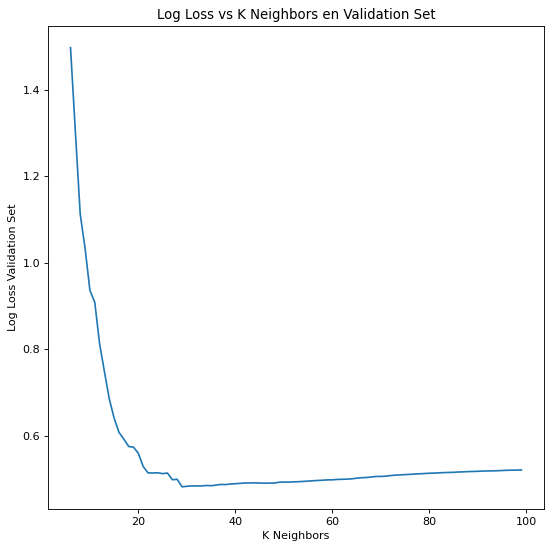

In [8]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(knn_data['K'], knn_data['Log Loss'])
plt.xlabel('K Neighbors')
plt.ylabel('Log Loss Validation Set')
plt.title('Log Loss vs K Neighbors en Validation Set')

In [9]:
knn_f1 = pd.DataFrame(dicc_f1)
knn_f1

,K,f1
0,1,0.784276
1,2,0.728860
2,3,0.782650
3,4,0.758197
4,5,0.784967
...,...,...
94,95,0.773869
95,96,0.772123
96,97,0.774223
97,98,0.774164


Text(0.5, 1.0, 'f1 Score vs K Neighbors en Validation Set')

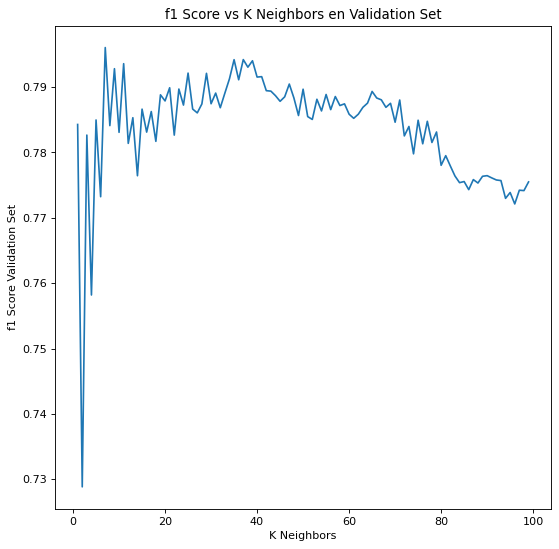

In [10]:
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(knn_f1['K'], knn_f1['f1'])
plt.xlabel('K Neighbors')
plt.ylabel('f1 Score Validation Set')
plt.title('f1 Score vs K Neighbors en Validation Set')

In [11]:
knn = KNeighborsClassifier(n_neighbors=25)
pipe = Pipeline([('preprocessing', preprocessor),('knn', knn)])

pipe.fit(X_train, y_train)

knn_preds = pd.DataFrame(pipe.predict_proba(test.drop(columns=['Opportunity_ID', 'Target']))[:, 1])

In [12]:
knn_preds['Opportunity_ID'] = test.Opportunity_ID.to_list()
knn_preds.columns= ['Target', 'Opportunity_ID']
knn_preds

,Target,Opportunity_ID
0,0.80,10689
1,0.88,10690
2,0.36,10691
3,0.04,10692
4,0.88,10693
...,...,...
1562,0.80,12364
1563,0.36,12365
1564,0.28,12366
1565,0.28,12367


In [13]:
knn_preds.loc[:, ['Opportunity_ID', 'Target']].to_csv('predictions/knn.csv')

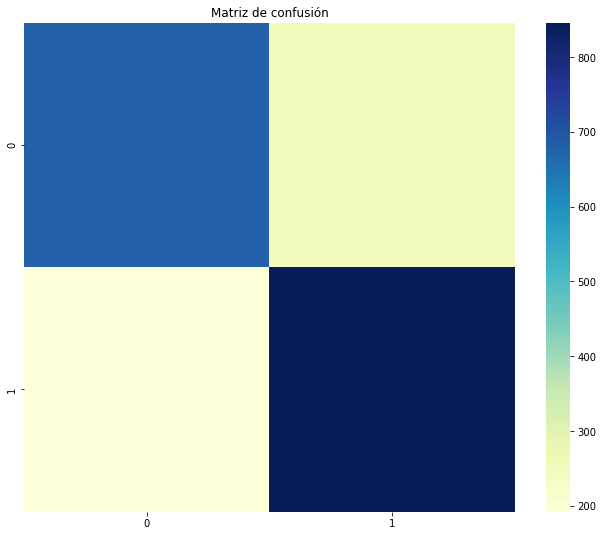

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 9))
plt.title('Matriz de confusión')
sns.heatmap(confusion_matrix(y_test, pipe.predict(X_test)), cmap='YlGnBu')
plt.show()